# Normalising a dataset

Code to take in a previously created hdf5 dataset and normalise it.

Does L2 normalisation on the input total masses per face.

HALFWAY THROUGH REFACTORING THIS!

In [26]:
import numpy as np
import h5py
import os
import sys
from collections import Counter
import matplotlib.pyplot as plt

# fixc this at some point
sys.path.append(r"C:\Users\ella_\Documents\GitHub\graphs_and_topology_for_chemistry")
sys.path.append(r"C:\Users\ella_\Documents\GitHub\icosahedron_projection")

from projection import helper_functions as h

These should be the only two bits you need to change

In [27]:
#save_dir=r'F:\Nextcloud\science\Datasets\converted_pdbbind\v2015'
#data_dir=r'F:\Nextcloud\science\Datasets\converted_pdbbind\v2015'
save_dir=r'F:\Nextcloud\science\Datasets\icostar_processed'
data_dir=r'F:\Nextcloud\science\Datasets\icostar_processed'

#train_filename = '2021_PDBBind_core_augmented_div4.hdf5'
train_filename = "TEST2.hdf5" #'Delaney_augmented_expanded.hdf5'# 
outfile=train_filename
#test_filename = "2021_PDBBind_core_augmented_div4_normalised.hdf5"
field = "icosahedron_level4"

### Functions

### Now lets do the normalisation.

First compute the maximum value in each element of the row.

_note:_ for finding max, we initialise the values to 0.1 to avoid divide by zero errors. This is fine as no isotope has a mass that low, so if max remains at 0.1 that means there is _never_ an atom in that spot, and so it will always end up mapped to -1 ((2*0/0.1)-1)
We have to do this in three passes as we need to use data computed in one pass in the next pass.

**Pass 1:**
Compute the elementwise mean and max of the data set, storing them in the arrays *mean_val* and *upper* respectively

**Pass 2:**
Use the mean to calculate the elementwise **standard deviation** and the **mean normalisation** of the data, storing them in **std_val** and **mean_normalisation** respectively.

**Pass 3**:
Use the standard deviation to calculate the elementwise standardisation, storing it in *standardisation*

### Have a look at the dataset

This code is here if you want to poke at the dataset by hand.

In [28]:
data_dir=data_dir
print(outfile)
hf = h5py.File(os.path.join(data_dir,outfile), 'r')

hf.keys()


TEST2.hdf5


<KeysViewHDF5 ['Compound ID', 'ESOL predicted log solubility in mols per litre', 'Minimum Degree', 'MolLogP', 'Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings', 'Number of Rotatable Bonds', 'PMI_1', 'PMI_2', 'PMI_3', 'Polar Surface Area', 'asphericity', 'eccentricity', 'icosahedron_level4', 'icosahedron_level4_L2_normalised', 'icosahedron_level4_mean_normalised', 'icosahedron_level4_std_normalised', 'inertial_shape_factor', 'invarient', 'measured log solubility in mols per litre', 'molID', 'num_ heteroatoms', 'num_H_acceptors', 'num_H_donors', 'num_atoms', 'num_bonds', 'num_exact_Mol_Wt', 'num_heavy_atoms', 'num_valence_electrons', 'radius_of_gyration', 'smiles', 'spherocity']>

In [29]:
num_of_rows, num_of_molecules, num_of_augments=h.basic_info_hdf5_dataset(
    hf, 
    label='molID')

num_of_ rows is:	325
num_of_molecules is:	 5
num_of_augments is:	65


In [30]:


hf.close()

In [31]:
outfile

'TEST2.hdf5'

## Normalise the training dataset

#### Open the dataset and create empty columns

In [32]:
# name of the new fields that we will add
norm_L2_field = f"{field}_L2_normalised"
norm_mean_field = f"{field}_mean_normalised"
norm_std_field = f"{field}_std_normalised"

In [33]:
# open dataset, create file handle and empty datasets
fh, data, data_L2_out, data_mean_out, data_std_out = h.Open_Train_File_Create_Normalised_Datasets(
                                    data_dir, 
                                    outfile, 
                                    field,
                                    norm_L2_field, 
                                    norm_mean_field,
                                    norm_std_field,
                                    label='molID')

TEST2.hdf5
num_of_ rows is:	325
num_of_molecules is:	 5
num_of_augments is:	65
row_shape is (5120, 3)


In [34]:
data

<HDF5 dataset "icosahedron_level4": shape (325, 5120, 3), type "<f4">

## Calculating the icosahedral nets averages etc from the training data

### This chunk calculates the invarients (upper, mean_val and std_val) and writes out the normalised datasets to the hdf5 file :)

In [35]:
upper, mean_val, std_val = h.parse_and_normalise_da_data(fh,
                                data,
                                num_of_rows,
                                data_L2_out,
                                data_mean_out,
                                data_std_out,
                                batch_size=10000)


Pass 1 through the data, calculating upper and mean_val
going from 0 to 325
Pass 2 through the data, calculating std_val and calcs and writes out the mean and L2 normalised data
going from 0 to 325
Pass 3 through the data, writes out the standardisation data
going from 0 to 325
Writing out upper, mean_val and std_val invarient nets


##### Look at some example data from the invarients

In [36]:
print(data[0])
print(upper[0])
print(upper[10:12])
print(mean_val[10:12])
print(std_val[10:12])

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[0.1 0.1 0.1]
[[0.1 0.1 0.1]
 [0.1 0.1 0.1]]
[[0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 0.]]


In [37]:
fh

<HDF5 file "TEST2.hdf5" (mode r+)>

### Write the new data out to the hdf5 file

L2 norm: Now write the new table, scaling each element to the range 
`[-1,1]`
The rest of the data is copied in

### Have a look at the new data

In [38]:
print(fh[field].shape)
print(fh[field][0].shape)
moo=fh[field][:,0]
print(moo.shape)

(325, 5120, 3)
(5120, 3)
(325, 3)


In [39]:
print(max(moo.flatten()))
counted_record1=Counter(moo.flatten())

0.0


In [40]:
record1=fh[field][0]
record1=record1.flatten()
print(f'max: {max(record1)}, mean: {np.mean(record1)}, min: {min(record1)}')
print(f'{Counter(record1)}')
counted_record1=Counter(record1)

max: 15.99899959564209, mean: 0.08849458396434784, min: 0.0
Counter({0.0: 15186, 1.008: 79, 12.011: 58, 15.999: 33, 14.007: 3, 13.019: 1})


<BarContainer object of 6 artists>

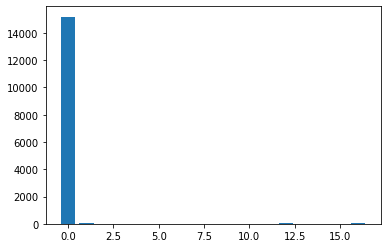

In [41]:
plt.bar(counted_record1.keys(), counted_record1.values())

In [42]:
plt.bar(counted_norm_record1.keys(), counted_norm_record1.values())

NameError: name 'counted_norm_record1' is not defined

In [43]:
fh.keys()

<KeysViewHDF5 ['Compound ID', 'ESOL predicted log solubility in mols per litre', 'Minimum Degree', 'MolLogP', 'Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings', 'Number of Rotatable Bonds', 'PMI_1', 'PMI_2', 'PMI_3', 'Polar Surface Area', 'asphericity', 'eccentricity', 'icosahedron_level4', 'icosahedron_level4_L2_normalised', 'icosahedron_level4_mean_normalised', 'icosahedron_level4_std_normalised', 'inertial_shape_factor', 'invarient', 'measured log solubility in mols per litre', 'molID', 'num_ heteroatoms', 'num_H_acceptors', 'num_H_donors', 'num_atoms', 'num_bonds', 'num_exact_Mol_Wt', 'num_heavy_atoms', 'num_valence_electrons', 'radius_of_gyration', 'smiles', 'spherocity']>

In [44]:
fh['icosahedron_level4_mean_normalised'][0][130:170]

array([[-0.11087076, -0.11087076, -0.11087076],
       [-0.00930462, -0.00930462, -0.00930462],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-0.00930462, -0.00930462, -0.00930462],
       [-0.23104618, -0.23104618, -0.23104618],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-0.00930462, -0.00930462, -0.00930462],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-0.14782768, -0.14782768, -0.14782768],
       [-0.14782768, -0.14782768, -0.14782768],
       [-0.14782768, -0.14782768, -0.14782768],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.   

In [231]:
fh['invarient/mean'][:]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)

In [33]:
outfile

'2021_PDBBind_refined_augmented_div4_normalised.hdf5'

## CLOSE FILE!

In [45]:
fh.close()

# Normalising the test dataset!
This is normalised using the icosahedrons upper and lower from the training dataset

Not sure that this is finished yet!

#### Open the test hdf5 file

In [34]:
# Open hdf5 file, calc basic details
outfile = test_filename
print(outfile)
fh = h5py.File(os.path.join(data_dir,outfile), 'r+')
num_of_rows, num_of_molecules, num_of_augments=h.basic_info_hdf5_dataset(fh, label='molID')
fh.close()

2021_PDBBind_core_augmented_div4_normalised.hdf5
num_of_ rows is:	23400
num_of_molecules is:	 195
num_of_augments is:	120


#### make some sensible column names

In [35]:
# name of the new fields that we will add
norm_L2_field = f"{field}_L2_normalised"
norm_mean_field = f"{field}_mean_normalised"
norm_std_field = f"{field}_std_normalised"

#### load up the data and create some empty datasets in the test hdf5 file

In [36]:
# open dataset, create file handle and empty datasets
# CREATES DATA
# open dataset, create file handle and empty datasets
# data_L2_out, data_mean_out, data_std_out are pointers to the dataset in the hdf5 file 
fh, data, data_L2_out, data_mean_out, data_std_out=Open_Train_File_Create_Normalised_Datasets(
                                    data_dir, 
                                    outfile, 
                                    field,
                                    norm_L2_field, 
                                    norm_mean_field,
                                    norm_std_field,
                                    label='molID')

2021_PDBBind_core_augmented_div4_normalised.hdf5
num_of_ rows is:	23400
num_of_molecules is:	 195
num_of_augments is:	120
row_shape is (5120, 3)


In [44]:
data_std_out

<HDF5 dataset "icosahedron_level4_std_normalised": shape (23400, 5120, 3), type "<f4">

In [38]:
std_val

array([[3.4092455, 3.4055579, 3.6645153],
       [3.4403386, 3.443217 , 3.720599 ],
       [3.4060273, 3.4006977, 3.6675954],
       ...,
       [3.4279206, 3.4281645, 3.695298 ],
       [3.4493935, 3.444969 , 3.7177188],
       [3.4687016, 3.4673758, 3.7299552]], dtype=float32)

#### Using the invarients from the training dataset, DO THE NORMALISATION!

In [39]:
h.parse_and_normalise_da_test_data(
                                fh,
                                data,
                                num_of_rows,
                                data_L2_out,
                                data_mean_out,
                                data_std_out,
                                batch_size=10000)

Pass 2 through the data, writing mean_normalisation and l2 norm
going from 0 to 10000
going from 10000 to 20000
going from 20000 to 23400
Pass 3 through the data, calculating and writing out standardisation
going from 0 to 10000
going from 10000 to 20000
going from 20000 to 23400


In [40]:
fh.keys()

<KeysViewHDF5 ['-logKd_over_Ki', 'EC_number', 'Kd_over_Ki', 'MolLogP', 'PDB_code', 'PMI_1', 'PMI_2', 'PMI_3', 'asphericity', 'eccentricity', 'icosahedron_level4', 'icosahedron_level4_L2_normalised', 'icosahedron_level4_mean_normalised', 'icosahedron_level4_normalised', 'icosahedron_level4_normalised2', 'icosahedron_level4_std_normalised', 'inertial_shape_factor', 'ligand_name', 'molID', 'num_ heteroatoms', 'num_atoms', 'num_bonds', 'num_exact_Mol_Wt', 'num_heavy_atoms', 'num_valence_electrons', 'protein_name', 'radius_of_gyration', 'reference', 'release_year', 'resolution', 'spherocity']>

In [42]:
fh['icosahedron_level4_mean_normalised'][0][130:170]

array([[-1.1674658 , -1.1656144 , -1.2578969 ],
       [-1.0418468 , -1.0385596 , -1.1142827 ],
       [-1.1473631 , -1.1455536 , -1.2333437 ],
       [-1.0428902 , -1.0414573 , -1.1186725 ],
       [-0.1659044 , -0.16887379, -0.25907838],
       [-0.7971767 , -0.7977518 , -0.84027123],
       [-0.44552803, -0.4450429 , -0.45772827],
       [-1.914735  , -1.9128029 , -2.1902425 ],
       [-0.9405442 , -0.9404738 , -1.0011014 ],
       [-1.0668917 , -1.0672481 , -1.1433274 ],
       [-0.93578964, -0.93288875, -0.99488306],
       [-1.0502902 , -1.0478317 , -1.1227767 ],
       [-0.93317175, -0.93284416, -0.9941256 ],
       [-0.04293096, -0.03952885, -0.11059463],
       [-1.0452738 , -1.0430309 , -1.1175942 ],
       [-0.7644902 , -0.7636587 , -0.80180985],
       [-0.96390486, -0.96200126, -1.0247307 ],
       [-0.88563687, -0.8834664 , -0.9375463 ],
       [-0.95211726, -0.9503882 , -1.0110421 ],
       [-0.9074423 , -0.9034893 , -0.95704305],
       [-0.9623416 , -0.96263087, -1.023

### Have a look at the new data

In [240]:
record1=fh[norm_L2_field][0]
record1=record1.flatten()
print(f'max: {max(record1)}, mean: {np.mean(record1)}, min: {min(record1)}')
print(f'{Counter(record1)}')
counted_record1=Counter(record1)

max: -0.09745293855667114, mean: -0.9987844824790955, min: -1.0
Counter({-1.0: 15276, -0.9747697: 17, -0.69936424: 14, -0.59954447: 11, -0.984114: 9, -0.943136: 8, -0.6494043: 6, -0.81070733: 6, -0.7478566: 3, -0.09745294: 2, -0.32242686: 2, -0.3342904: 1, -0.73864985: 1, -0.95752573: 1, -0.65187407: 1, -0.9780667: 1, -0.46595228: 1})


In [ ]:
field + "_normalised"

In [194]:
record1=fh[norm_field][0]
record1=record1.flatten()
print(f'max: {max(record1)}, mean: {np.mean(record1)}, min: {min(record1)}')
counted_norm_record1=Counter(record1)
print(f'{Counter(record1)}')

NameError: name 'norm_field' is not defined

<BarContainer object of 111 artists>

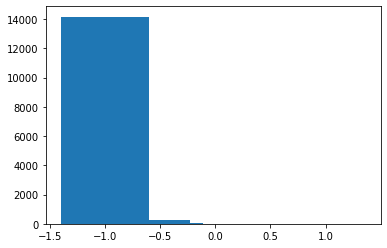

In [195]:
plt.bar(counted_record1.keys(), counted_record1.values())

In [196]:
plt.bar(counted_norm_record1.keys(), counted_norm_record1.values(),width=0.05)

NameError: name 'counted_norm_record1' is not defined

## CLOSE FILE!

In [45]:
fh.close()

In [46]:
test_filename

'2021_PDBBind_core_augmented_div4_normalised.hdf5'

# Graphs follow

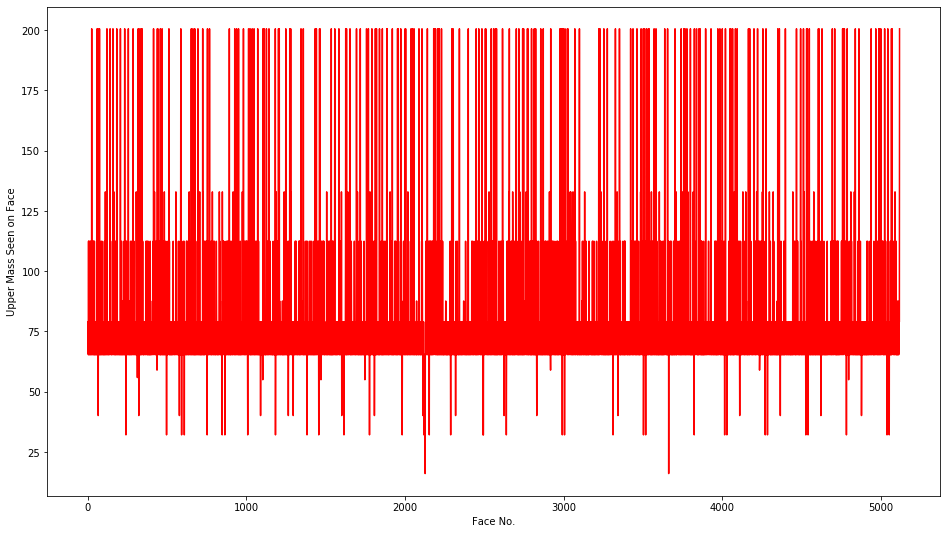

In [198]:
plt.figure(figsize=(16,9))
plt.plot(upper.transpose()[0],color='r')
plt.xlabel('Face No.')
plt.ylabel('Upper Mass Seen on Face')
plt.savefig(train_filename.split('.')[0] + 'red.png',dpi = 300)

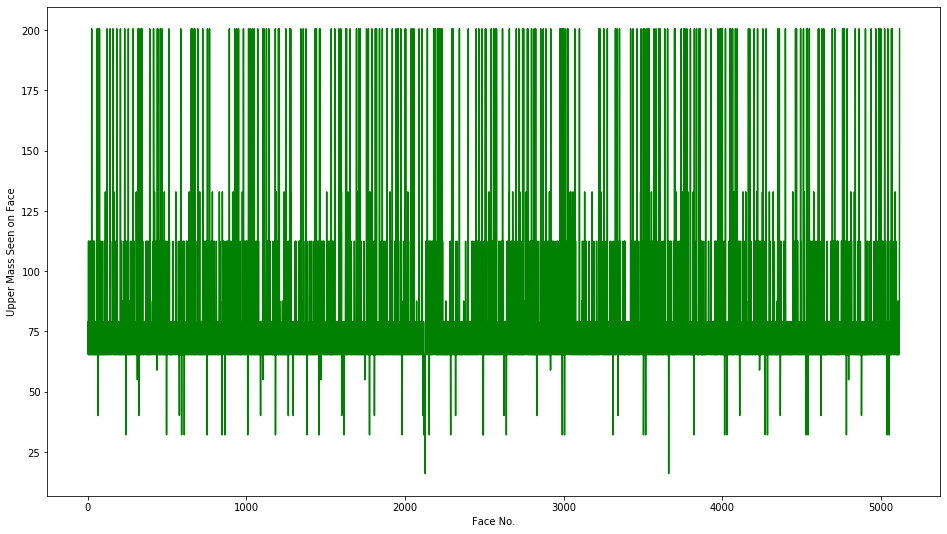

In [329]:
plt.figure(figsize=(16,9))
plt.plot(upper.transpose()[1],color='g')
plt.xlabel('Face No.')
plt.ylabel('Upper Mass Seen on Face')
plt.savefig(train_filename.split('.')[0] + 'green.png',dpi = 300)

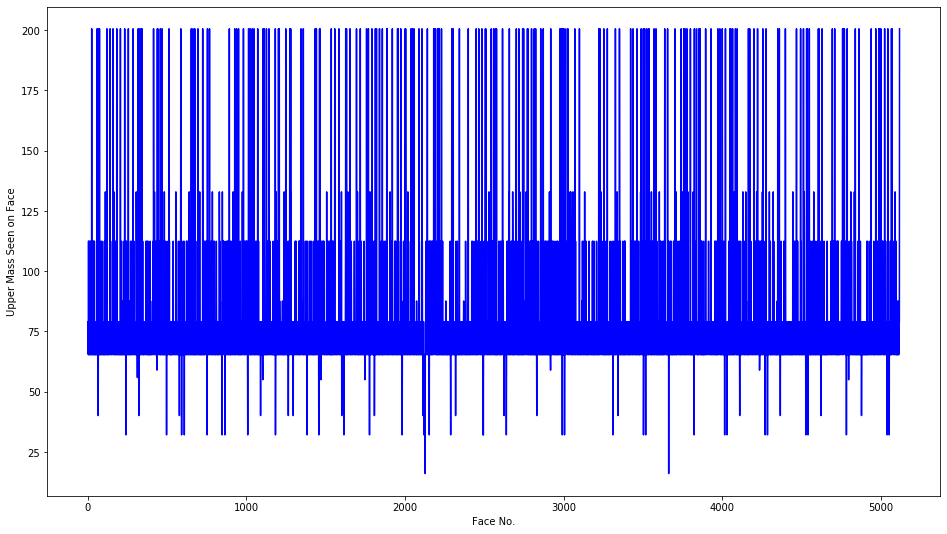

In [330]:
plt.figure(figsize=(16,9))
plt.plot(upper.transpose()[0],color='b')
plt.xlabel('Face No.')
plt.ylabel('Upper Mass Seen on Face')
plt.savefig(train_filename.split('.')[0] + 'blue.png',dpi = 300)

In [331]:
m.coords=upper
m.coords

NameError: name 'm' is not defined

In [336]:
field

'icosahedron_level4'

In [40]:
upper.flatten()

array([32.067, 32.067, 46.074, ..., 32.067, 32.067, 44.078], dtype=float32)

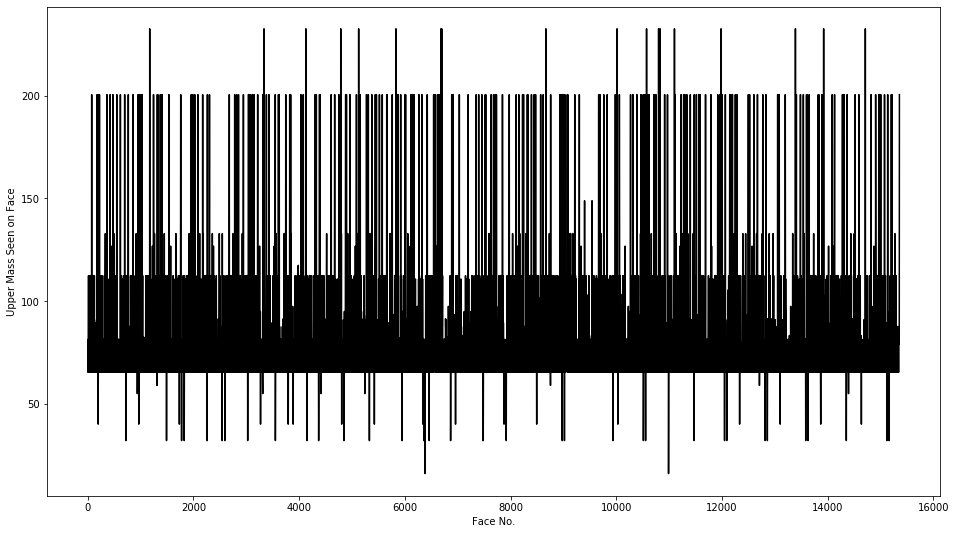

In [332]:
plt.figure(figsize=(16,9))
plt.plot(upper.flatten(),color='k')
plt.xlabel('Face No.')
plt.ylabel('Upper Mass Seen on Face')
plt.savefig(test_filename.split('.')[0] + 'upper_flatten_all.png',dpi = 300)

In [335]:
record11=fh[field][0]
record11=record11.flatten()
plt.figure(figsize=(16,9))
plt.plot(record11,color='k')
plt.xlabel('Face No.')
plt.ylabel('Upper Mass Seen on Face')
plt.savefig(test_filename.split('.')[0] + 'test_record_1_flattend_unnormed.png',dpi = 300)

ValueError: Not a location (invalid object ID)

In [334]:
plt.figure(figsize=(16,9))
plt.plot(record1,color='b')
plt.xlabel('Face No.')
plt.ylabel('Upper Mass Seen on Face')
plt.ylabel('Upper Mass Seen on Face')
plt.savefig(test_filename.split('.')[0] + 'test_record_all.png',dpi = 300)

SyntaxError: invalid syntax (<ipython-input-334-de937154b3fd>, line 4)

In [11]:
# name of the new field that we will add
norm_field = f"{field}_normalised2"

In [12]:
# Open, calc basic details
fh = h5py.File(os.path.join(data_dir,outfile), 'r+')
num_of_rows, num_of_molecules, num_of_augments=basic_info_hdf5_dataset(fh, label='molID')

num_of_ rows is:	325
[0.0, 1.0, 2.0, 3.0, 4.0]
num_of_molecules is:	 5
num_of_augments is:	65


In [13]:
# grabs the original data
data = fh[field]
# makes a new dataset of the same size
data_out = fh.create_dataset(norm_field, data.shape, data.dtype)

In [14]:
row_count = data.shape[0]
if not num_of_rows == row_count:
    print('Error: num_of_rows from molID is not the same as the number found for {field}')
row_shape = data.shape[1:]
print(f'row_shape is {row_shape}')

row_shape is (5120, 3)


In [56]:
import projection
from projection.molecule import Molecule
from projection.pdbmolecule import PDBMolecule
from projection.mol2molecule import Mol2Molecule
from projection.face import Face
from projection.ico import Ico

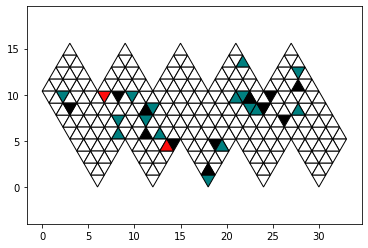

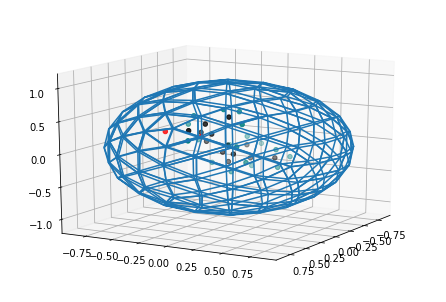

In [57]:
m=Molecule('CC(C)Cc1ccc(cc1)C(C)C(=O)O')
i = Ico(m,2)
i.draw2D()
i.draw3D()

In [59]:
m.coords=upper
m.coords

array([[15.999, 15.999, 15.999],
       [12.011, 12.011, 12.011],
       [15.999, 15.999, 15.999],
       ...,
       [15.999, 15.999, 15.999],
       [15.999, 15.999, 15.999],
       [15.999, 15.999, 26.018]], dtype=float32)

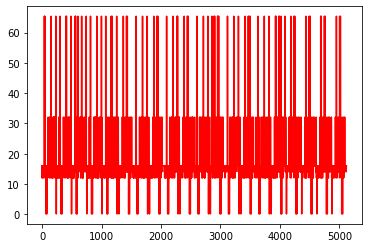

In [75]:
plt.plot(upper.transpose()[0],color='r')

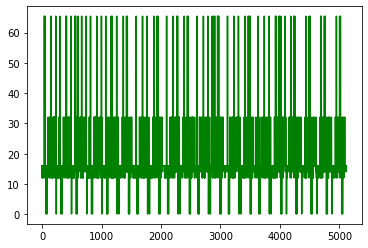

In [76]:
plt.plot(upper.transpose()[0],color='g')

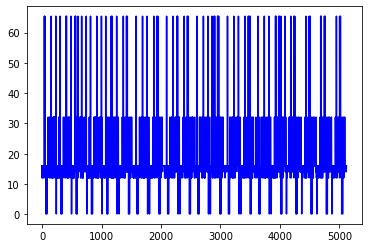

In [77]:
plt.plot(upper.transpose()[0],color='b')

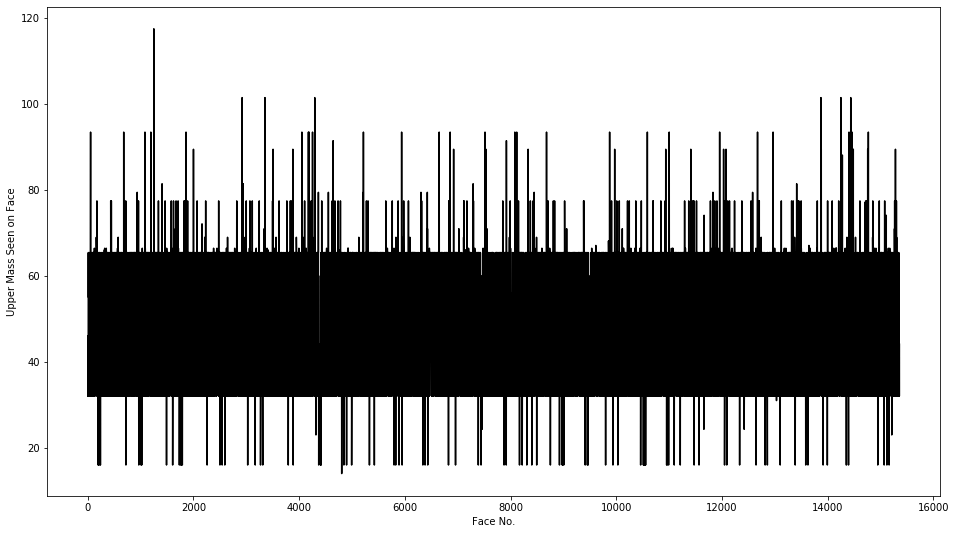

In [43]:
plt.figure(figsize=(16,9))
plt.plot(upper.flatten(),color='k')
plt.xlabel('Face No.')
plt.ylabel('Upper Mass Seen on Face')
plt.savefig(test_filename.split('.')[0] + 'test_upper_all.png',dpi = 300)

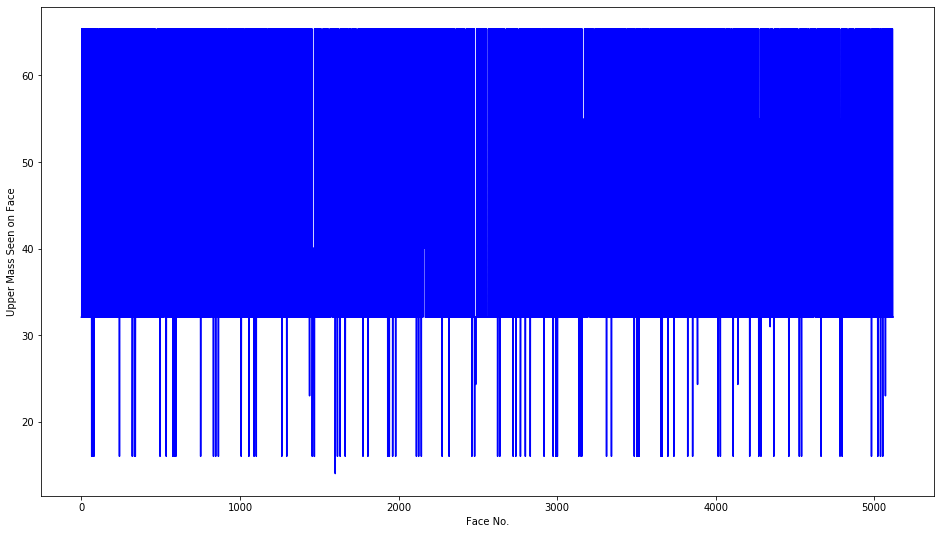

In [36]:
plt.figure(figsize=(16,9))
plt.plot(record1.transpose()[0],color='b')
plt.xlabel('Face No.')
plt.ylabel('Upper Mass Seen on Face')
plt.savefig(test_filename.split('.')[0] + 'blue.png',dpi = 300)

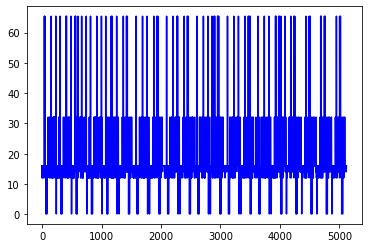

In [77]:
plt.figure(figsize=(16,9))
plt.plot(upper.transpose()[0],color='b')
plt.xlabel('Face No.')
plt.ylabel('Upper Mass Seen on Face')
plt.savefig(test_filename.split('.')[0] + 'blue.png',dpi = 300)

### Trying to plot an upper icosahedron not finihsed

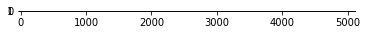

In [70]:
plt.imshow([upper.transpose()[0],upper.transpose()[1]], cmap='hot', interpolation='nearest')
plt.show()

In [112]:
import projection
from projection.molecule import Molecule
from projection.pdbmolecule import PDBMolecule
from projection.mol2molecule import Mol2Molecule
from projection.face import Face
from projection.ico import Ico

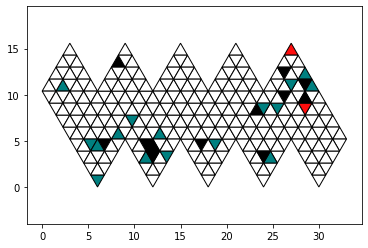

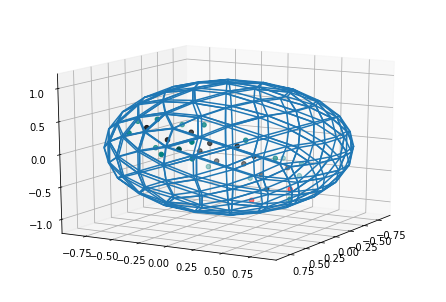

In [113]:
m=Molecule('CC(C)Cc1ccc(cc1)C(C)C(=O)O')
i = Ico(m,2)
i.draw2D()
i.draw3D()